### Nuißl Sandra, 14.08.2023
## "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen"
### - Implementierung und Evaluierung der Topic Modelling Modelle: BERTopic -

<hr>

## **Inhaltsverzeichnis**

<ul>1. Aufbau des Jupyter Notebooks</ul>
<ul>2. Instalation und Imports</ul>
    <ul>
     <ul>2.1. Installationen</ul>
     <ul>2.2. Imports</ul>
    </ul>
<ul>3. Laden der bereinigten Amazon Daten</ul>
<ul>4. Implementierung des Modells</ul>
    <ul>
     <ul>4.1. Data Preparation</ul>
     <ul>4.2. Bestimmung der Parameter</ul>
     <ul>4.2. Modellierung</ul>
     <ul>4.3. Visualisierung</ul>
    </ul>
<ul>5. Evaluierung</ul>
    <ul>
     <ul>5.1. Coherence score</ul>
     <ul>5.2. Perplexity</ul>
     <ul>5.3. Similarity</ul>
    </ul>
<hr>

## 1. Aufbau des Jupyter Notebooks
Dieses Jupyter Notebook ist Teil der Master Thesis "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen".
Es beinhaltet die Implementierung des Topic Modelling Modells von __BERTopic__ sowie dessen Evaluierung.

Die theoretischen Inhalte zu diesem Notebook sind der schriftlichen Ausarbeitung dieser Masterarbeit unter den Kapiteln "5. 4.	BERTopic" und "6.	Empirische Evaluierung der Modelle" zu entnehmen.

## 2. Instalationen und Imports
### 2.1. Installationen

In [ ]:
# Instalationen
%pip install nltk
%pip install tables
%pip install gitly==1.0.1
%pip install plotly>4.0.0

# Beschleunigung
# Quelle: https://medium.com/rapids-ai/faster-topic-modeling-with-bertopic-and-rapids-cuml-5c7559aba898
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
%pip install bertopic

### 2.2. Imports

In [ ]:
# Imports und Initalisierungen
import numpy as np
import pandas as pd
import tables

# Progressbar
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from tqdm.auto import tqdm
tqdm_notebook.pandas()

# Beschleunigung
import joblib
from joblib import Parallel, delayed

# Preprocessing
import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

# Datenvisualisierung
import plotly.express as px
from gitly.colab.plot import GitlyPlotter
gitly = GitlyPlotter('github')              # Instanziierung des Objekts

# Modelling
nltk.download('omw-1.4')
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# Evaluierung
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


There are few libs and modules that should be installed in Colab in order to generate static plots from Plotly.
Summary: Install Orca, update plotly and update apt-get

apt-get update
pip install plotly>=4.0.0
wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
chmod +x /usr/local/bin/orca
apt-get install xvfb libgtk2.0-0 libgconf-2-4
Done. Have fun! :)


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Laden der bereinigten Amazon Daten

In [ ]:
# Review Daten laden
reviews_df = pd.read_hdf('Cleaned_Sport_and_Outdoors.h5')

# Ausgabe
pd.concat([reviews_df], axis=1, sort = False, keys = ["Bereinigter Datensatz: Sport and Outdoors"])

Bereinigter Datensatz: Sport and Outdoors  \
                                                reviewText   
0                  What a spectacular tutu! Very slimming.   
1        What the heck? Is this a tutu for nuns? I know...   
2                        Exactly what we were looking for!   
3        I used this skirt for a Halloween costume and ...   
4        This is thick enough that you can't see throug...   
...                                                    ...   
2264636                     Wife laughs at me but it works   
2264637  2XU makes great compression shorts. A bit more...   
2264638  These are my favorite compression shorts for r...   
2264639  Love the shorts.. amazing comfortable, perfect...   
2264640  I have a briley bolt release paddle installed ...   

                                                                          \
                                               cleanedText  year overall   
0                               spectacular tutu veri slim  2015     5.0   
1        heck tutu nun know cut still also nt sever lay...  2015     1.0   
2                                               exact look  2015     5.0   
3        use skirt halloween costum glue bunch feather ...  2014     5.0   
4        thick enough ca nt see veri long sure check di...  2014     4.0   
...                                                    ...   ...     ...   
2264636                                    wife laugh work  2018     4.0   
2264637  xu make great compress short bit expens well w...  2018     5.0   
2264638  favorit compress short run thinnest materi run...  2018     5.0   
2264639  love short amaz comfort perfect compress perfe...  2018     5.0   
2264640  briley bolt releas paddl instal a xplor sport ...  2017     5.0   

                                                                      \
            brand                                              title   
0        BubuBibi                           Adult Ballet Tutu Yellow   
1        BubuBibi                           Adult Ballet Tutu Yellow   
2        BubuBibi                           Adult Ballet Tutu Yellow   
3        BubuBibi                           Adult Ballet Tutu Yellow   
4        BubuBibi                           Adult Ballet Tutu Yellow   
...           ...                                                ...   
2264636  Columbia                               Columbia Bora booney   
2264637       2XU                  2XU Men's Core Compression Shorts   
2264638       2XU                  2XU Men's Core Compression Shorts   
2264639       2XU                  2XU Men's Core Compression Shorts   
2264640       STS  T&amp;s Shell Catcher Beretta A400 Multitarget...   

                     
               asin  
0        0000032034  
1        0000032034  
2        0000032034  
3        0000032034  
4        0000032034  
...             ...  
2264636  B01HJDZ34I  
2264637  B01HJGAJ9O  
2264638  B01HJGAJ9O  
2264639  B01HJGAJ9O  
2264640  B01HJHHBHG  

[2264641 rows x 7 columns]

#### __Verleinerung des Datensatzes__
BERTopic ist mithilfe der GPU in der Lage größere Datenmengen zu verarbeiten. Jedoch benötigt die Verwendung von UMAP große Kapazitäten der System-RAM. Da aber im Rahmen dieser Masterarbeit durch die begrenzten RAM der Datensatz verkeleinert werden musste, wird für alle Topic Modelling Modelle der gleiche Datensatz verwendet. Dadurch können die Ergebnisse der Evaluierung besser verglichen werden.

In [ ]:
# Verleinerung des Datensatzes Aufgrund der Performence
reviews_df = reviews_df.iloc[ :100000,]

# Umwandeln der Daten in eine Liste
docs_list = reviews_df["reviewText"].to_list()

## 4. Implementierung des Modells
### 4.1. Data Preparation
Da es sich bei BERTopic um ein kontextualisiertes Modell handelt und die Informationen aus dem Kontext der Dokumente erschließt, werden nicht alle Vorverarbeitungsschritte benötigt (Bianchi, 2021). Im Folgenden werden lediglich die Stopwords und Satzzeichen entfernt, sowie ein Lowercasing durchgeführt.

In [ ]:
# Kleine Pipeline zum Preprocessing der Review Daten
def small_preprocessing(in_string):
    stop_words = stopwords.words('english')                                        # Definition der Stopwords
    in_string = in_string.lower()                                                  # Lowercasing
    in_string = in_string.translate(str.maketrans('', '', string.punctuation))     # Entfernung von Satzzeichen
    words = in_string.split()                                                      # Tokenisierung
    words = [word for word in words if word not in stop_words]                     # Entfernung von Stopwörtern
    cleaned_text = " ".join(words)                                                 # Zusammenführen

    return cleaned_text

In [ ]:
# Data Preprocessing durchführen
cleaned_list = Parallel(n_jobs=1)(delayed(small_preprocessing)(in_string) for in_string in tqdm(docs_list,
                                                                                                desc ="Status des Preprocessings: ",
                                                                                                total = len(docs_list)))
# Ausgabe
print("Ergebnis der Bereinigung:", cleaned_list[0:10])

Status des Preprocessings:   0%|          | 0/100000 [00:00<?, ?it/s]

Ergebnis der Bereinigung: ['spectacular tutu slimming', 'heck tutu nuns know cut still also arent several layers tutu making poof lays flat needless say returned', 'exactly looking', 'used skirt halloween costume glued bunch feathers exactly needed liked elastic waist didnt dig muffin top two things note though little long cut 8 inches really easy ii seethru bc unlined get pair yellow shorts wear underneath hadnt planned', 'thick enough cant see long sure check dimensions ended cutting shorter', 'arrived time nice atlas easy read', 'road map useful topographical map dont think would good kind orienteering nice quality tons details much road atlas', 'comprehensive atlas happy much detail wish detailed map syracuse could use navigate city', 'delorme always made best book maps usa three thumbs', 'youre interested exploring area new york beyond metropolitan areas delorme atlas gazetteer best bet years ive collected gazetteers quite states theyve come handy exploring outoftheway places im f

### 4.2. Bestimmung der Parameter

####__Embedding__

Zu Beginn des Modells werden die bereinigten Textdaten in numerische Daten konvertiert.  Das Framework von „SentenceTransformer“ von SBERT stellt eine Funktion zur Verfügung, welche eine verdichtete Vektordarstellung der Amazon Text Daten ermöglicht. Hierfür wird die Klasse „SentenceTransformer“ aufgerufen und das gewünschte Sprachmodelle in dem Parameter „embedding_model“ gespeichert (Grootendorst, BERTopic, 2023).

In [ ]:
# Schritt 1 - Embadding
# Quelle: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
# Vektorisierung mithilfe des SBERT Embeddings
# Quelle: https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#topic-term-matrix
embeddings = embedding_model.encode(cleaned_list, show_progress_bar=True)

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

#### __Dimensionsreduktion__
Im folgenden wird UMAP, welches bei BERTopic als Standard hinterlegt ist, initialisiert und durchgeführt. Es hat den Vorteil bei niedriger Dimensionalität die lokalen hochdimensionalen Strukturen zu erhalten. Hierfür muss U ggf. „umap-learn“ mithilfe von „pip install“ installiert werden (Grootendorst, Topic Modeling with BERT, 2020).

In [ ]:
# Schritt 2 - Dimensionsreduktion
# Quelle: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview
umap_model = UMAP(n_neighbors=15, n_components=3, min_dist=0.0, metric='cosine', verbose=True)

In [ ]:
# Durchführen der Dimensionsreduktion
umap_embeddings = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=3, verbose=True)
Fri Aug  4 16:03:39 2023 Construct fuzzy simplicial set
Fri Aug  4 16:03:39 2023 Finding Nearest Neighbors
Fri Aug  4 16:03:39 2023 Building RP forest with 21 trees
Fri Aug  4 16:03:47 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Fri Aug  4 16:04:08 2023 Finished Nearest Neighbor Search
Fri Aug  4 16:04:11 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Aug  4 16:05:06 2023 Finished embedding


#### __Clustering__

Nach der Dimensionsreduktion wird das dichtebasierte Clustering Verfahren HDBSCAN initialisiert, welches Themen unterschiedlicher Formen identifizieren kann und ebenfalls bei BERTopic als Default hinterlegt ist (Grootendorst, Topic Modeling with BERT, 2020). Mithilfe der Parrallelisierung der verfügbaren CPU Kerne kann Prozess beschleunigt werden (McInnes, Healy, & Astels, 2016).

In [ ]:
# Schritt 3 - Clustering
# Quelle: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview
hdbscan_model = HDBSCAN(min_cluster_size=15,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True,
                        core_dist_n_jobs=-1)

In [ ]:
# Durchführen des Clusterings
cluster = hdbscan_model.fit(umap_embeddings)

In [ ]:
# Speichern der Informationen in einen DataFrame
# Quelle: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
result_df = pd.DataFrame(umap_embeddings, columns=['x', 'y', 'z'])
result_df['labels'] = cluster.labels_

# Trennen der Cluster von den Ausreißern
outliers_df = result_df.loc[result_df.labels == -1, :]
clustered_df = result_df.loc[result_df.labels != -1, :]

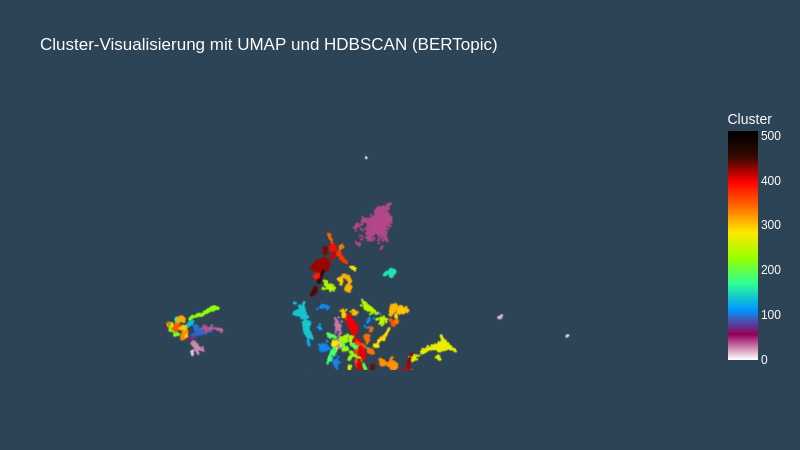

In [ ]:
# Graphische Darstellung
# Farben
My_colors = ['rgb(255,255,255)', 'rgb(150,0,90)', 'rgb(0,152,255)',
             'rgb(44,255,150)', 'rgb(151,255,0)', 'rgb(255,234,0)',
             'rgb(255,111,0)', 'rgb(255,0,0)','rgb(50,10,0)', 'rgb(0,0,0)']

# Erstellen eines 3D Scatterplots für die Clusterpunkte
clustered_fig = px.scatter_3d(clustered_df, x='x', y='y', z='z', color='labels',
                    opacity=0.9,
                    color_continuous_scale= My_colors,
                    title='Cluster-Visualisierung mit UMAP und HDBSCAN (BERTopic)',
                    labels={'labels': 'Cluster'})

# Hinzufügen eines 3D Scatterplots für die Ausreißer
#outlier_fig = px.scatter_3d(outliers_df, x='x', y='y', z='z', color='labels', opacity=0.09)
#clustered_fig.add_trace(outlier_fig.data[0])

# Optische Anpassungen
# Marker
clustered_fig.update_traces(marker_size=1.5)

# Achsen
clustered_fig.update_layout(scene = dict(
                                xaxis = dict(backgroundcolor="#2D4356", gridcolor="#2D4356", zerolinecolor="#2D4356", tickfont=dict(color="#2D4356"), title=""),
                                yaxis = dict(backgroundcolor="#2D4356", gridcolor="#2D4356", zerolinecolor="#2D4356", tickfont=dict(color="#2D4356"), title="",),
                                zaxis = dict(backgroundcolor="#2D4356", gridcolor="#2D4356", zerolinecolor="#2D4356", tickfont=dict(color="#2D4356"), title="")))

# Layout
clustered_fig.update_layout(scene_camera=dict(eye=dict(x=0.1, y=-0.3, z=-0.2)),
                            plot_bgcolor='#2D4356',
                            paper_bgcolor='#2D4356',
                            font_color='white')

# Ausgabe
gitly.show(clustered_fig)

#### __Themenrepräsentation__

Die Reviews, welche ein Cluster bilden, werden zu einem Dokument zusammengefasst. Durch die Identifikation und die Zählung der Häufigkeiten verschiedener Wörter innerhalb eines Clusters, kann herausgefunden werden, auf Basis welcher Inhalte sich diese voneinander unterscheiden. Die Topics lassen sich durch die häufigsten Wörter repräsentieren (Grootendorst, Topic Modeling with BERT, 2020).

In [ ]:
# Bestimmung der übrigen Parameter
# Quelle: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview
# Schritt 4 - Tokenisierung
tokenizer_model = CountVectorizer(stop_words="english")

# Schritt 5 - Themen repräsentieren
ctfidf_model = ClassTfidfTransformer()

#### __Finetuning__
Für eine Optimierung, werden die repräsentativsten Reviews pro Topic extrahiert, indem eine Stichprobe aus den Dokumenten pro Cluster entnommen wird. Über die Relevanz der Dokumente entscheidet die Kosinusähnlichkeit der c-TF-IDF-Darstellung. Im nächsten Schritt wird dieser Vorgang für die wichtigste Wörter eines Dokuments wiederholt. Aus diesen Informationen ergibt sich eine Themeneinbettung, welche für einen weiteren Vergleich mit den Wörtern herangezogen wird, um die repräsentativsten Wörter zu extrahieren und auf diese Weise eine Beschreibung des Topics zu definieren (Grootendorst, KeyBERTInspired, 2023).

In [ ]:
# Schritt 6 - (Optional) Fine-tuning Themenrepräsentation
# Quelle: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview
representation_model = KeyBERTInspired()

### 4.3. Modellierung
#### Initialisierung des Modells

Die oben definirten Variablen, werden nun als Parmeter in das Modell übergeben (Grootendorst, BERTopic, 2023).

In [ ]:
# BERTopic: Initialisieren des Modells mit den vordefinierten Parametern
# Quelle: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview
bert_model = BERTopic(embedding_model=embedding_model,            # Schritt 1 - Embadding
                      umap_model=umap_model,                      # Schritt 2 - Dimensionsreduktion
                      hdbscan_model=hdbscan_model,                # Schritt 3 - Clustering
                      vectorizer_model=tokenizer_model,           # Schritt 4 - Tokenisierung
                      ctfidf_model=ctfidf_model,                  # Schritt 5 - Extraktion von Topic Wörtern
                      representation_model=representation_model,  # Schritt 6 - Fine Tuning
                      calculate_probabilities=True,
                      verbose=True)

#### Anwendung auf den Amazon Datensatz

Mithilfe der Funktion "fit_transform()" kann das Modell auf den Amazon Datensatz angewendet werden (Grootendorst, BERTopic, 2023).

In [ ]:
# BERTtopic: fit the Model
# Quelle: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview
topics, probabilities = bert_model.fit_transform(cleaned_list)

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

2023-08-08 12:27:17,269 - BERTopic - Transformed documents to Embeddings


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=3, verbose=True)
Tue Aug  8 12:27:17 2023 Construct fuzzy simplicial set
Tue Aug  8 12:27:17 2023 Finding Nearest Neighbors
Tue Aug  8 12:27:17 2023 Building RP forest with 21 trees
Tue Aug  8 12:27:24 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Tue Aug  8 12:27:44 2023 Finished Nearest Neighbor Search
Tue Aug  8 12:27:47 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Aug  8 12:28:40 2023 Finished embedding


2023-08-08 12:28:40,672 - BERTopic - Reduced dimensionality
2023-08-08 12:54:00,676 - BERTopic - Clustered reduced embeddings


### 4.4.  Visualisierung

BERTopic identifiziert automatisch die ideale Anzahl von Topics und gibt diese über die Funktion "get_topic_info()" inklusiver der wichtigsten Informationen aus. Hierzu zählen unter anderem die Namensbezeichnung des Topics, welche sich aus den wichtigsten Wörtern für dieses Topic zusammensetzt, und Für das Thema repräsentative Wörter und Reviews zur veranschaulichung. Neben diesen Informationen bietet BERTopic eine Reihe unterschidelichster Visualisierungsmöglichkeiten zur Untersuchung der Daten (Amy, 2022).

In [ ]:
# Anzahl der Identifizierten Topics
number_of_topics = len(bert_model.get_topic_info())
print(f"Es wurden mithilfe des Modells BERTopic {number_of_topics} Topics identifiziert.")

Es wurden mithilfe des Modells BERTopic 500 Topics identifiziert.


In [ ]:
# Ausgabe einer Liste von Topics
# Quelle: https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504
top_topics_df = bert_model.get_topic_info()

# Ausgabe
print("Ausgabe der 10 wichtigsten Topics")
print("- Die Topic Nummer -1 steht für alles, was keinem Thema zugeordnet werden konnte -")
print("")
top_topics_df.head(11)

Ausgabe der 10 wichtigsten Topics
- Die Topic Nummer -1 steht für alles, was keinem Thema zugeordnet werden konnte -



,Topic,Count,Name,Representation,Representative_Docs
0,-1,29690,-1_fit_quality_size_small,"[fit, quality, size, small, bag, fits, tight, ...",[used bag two music festivals 9 days total im ...
1,0,4797,0_knife_knives_knifes_sharp,"[knife, knives, knifes, sharp, sharpener, shar...",[nothing best case price sharp knife sharp loo...
2,1,2155,1_meals_meal_foods_food,"[meals, meal, foods, food, rations, breakfast,...","[favorite mountain house meal, review refers c..."
3,2,1835,2_gloves_glove_palms_hands,"[gloves, glove, palms, hands, fingers, palm, s...",[comfortable gloves wrist bands feel good tigh...
4,3,1232,3_helmet_helmets_price_forehead,"[helmet, helmets, price, forehead, skull, head...","[great helmet love, good helmet price, great h..."
5,4,1148,4_frisbee_frisbees_discs_disc,"[frisbee, frisbees, discs, disc, toy, games, a...","[best frisbee disc style ever, frisbee ever bu..."
6,5,1141,5_mat_mats_yoga_towel,"[mat, mats, yoga, towel, pilates, cushion, cus...",[comfortable mat like much better thin yoga ma...
7,6,1104,6_stove_stoves_burners_burner,"[stove, stoves, burners, burner, cookware, pro...",[picked stove 35 ago looking better backpackin...
8,7,1081,7_bowstring_bows_bow_crossbow,"[bowstring, bows, bow, crossbow, crossbows, ar...","[string fits bow works great, happy bow string..."
9,8,960,8_boxes_tackle_box_lures,"[boxes, tackle, box, lures, supplies, slots, h...","[every tackle box one, cool tackle box nice sm..."


#### __Topic Word Score__

Die Balkendiagramme stehen für die zehn wichtigsten Topics.Für jedes Topic wurden wiederum die fünf wichtigsten Wörter ausgegebem, dessen relevanz für das Thema durch die Länge des Balkens festgelegt ist (Amy, 2022).

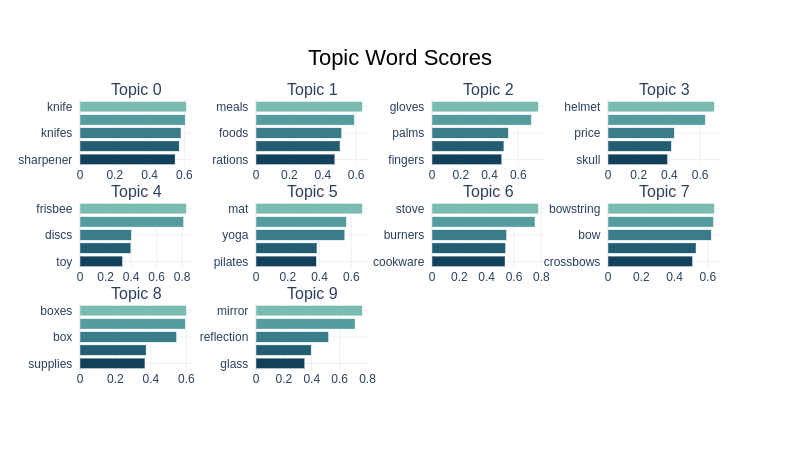

In [ ]:
# Visualisierung der Top 10 Topics inkl. der wichtigsten Wörter
# Quelle: https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504
topics_fig = bert_model.visualize_barchart(top_n_topics=10)

# Update Layout
topics_fig.update_traces(marker_color=px.colors.sequential.Darkmint_r)

# Speichern als HTML
topics_fig.write_html("BERT_Topics.html")

# Ausgabe
gitly.show(topics_fig)

#### __Topic Word Score__

Eine weitere Darstellungsform, um die Sinnhaftigkeit der Topics zu erörtern ist die Visualisierung der Dokumenteneinbettungen. Jeder Punkt steht für einen Review und jede Farbe repräsentiert ein Topic. Aus vereinfachungsgründen wurden die ersten Top zehn Topics in die Graphik mit aufgenommen (Nick, 2023).

BERTopic bietet hierfür ebenfalls eine standartisierte Graphik, welche einen ähnlichen Aufbau wie die Dimensionsreduktion und das Clustering in der Beschreibung der Implementierung aufweißt. Es werden lediglich die Daten in einen zwei- statt drei- Dimensionalen Raum dargestellt.

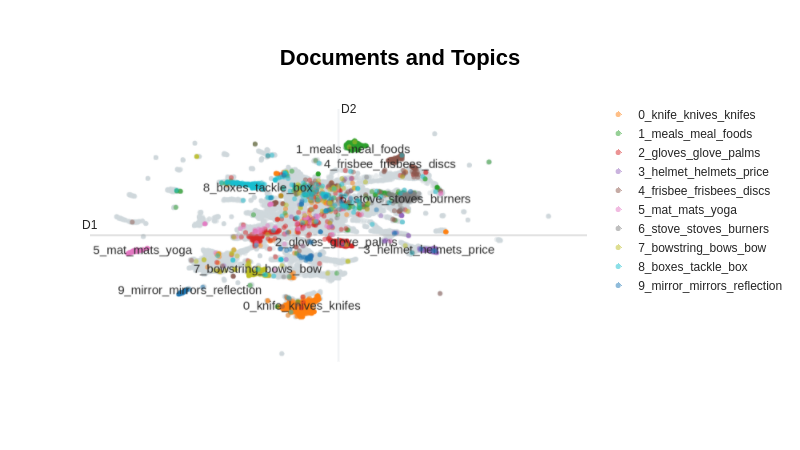

In [ ]:
# Visualisierung der Dokumente in
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/documents.html#bertopic.plotting._documents.visualize_documents
topic_doc_fig = bert_model.visualize_documents(docs_list, topics = [0,1,2,3,4,5,6,7,8,9])

# Speichern als HTML
topic_doc_fig.write_html("BERT_Topics_Docs.html")

# Ausgabe
gitly.show(topic_doc_fig)

## 5. Evaluierung
Um die Topic Modelling Modelle bewerten zu können, ist es wichtig geeignete Metriken und Validierungsmöglichkeiten heranzuziehen. Auf diese Weise lässt sich herausfinden wie gut die Themenklassifizierung funktioniert hat (Pascual, Topic Modeling: An Introduction, 2019). Im Allgemeinen lassen sich zwei verschiedenen Herangehensweisen unterscheiden: die Intrinsische und die extrinsische Clustervalidität.Im Rahmen dieser Masterarbeit wird auf intrinsische Clustervaliditätsmetriken zurückgegriffen, welche strukturelle Eigenschaften der Cluster berücksichtigt und semantische Merkmale vergleichen (Rüdiger, Antons, Joshi, & Salge, 2022).

Befor mit der Anwendung der Evaluierungsmetriken begonnen werden kann, müssen die notwendigen Parameter dafür erzeugt werden.

In [ ]:
# Vorverarbeitungsschritte für die Paramtert der Evaluierungsmodelle
# Quelle: https://www.theanalyticslab.nl/topic-modeling-with-bertopic/
# Erstellen einer Liste mit den bereinigten Review Daten
text_list = reviews_df["cleanedText"]

# Erzeugen eines DataFrames mit den relevanten Informationen
documents_df = pd.DataFrame({"Document": text_list,
                             #"ID": range(len(text_list)),
                             "Topic_number": topics})

# Gruppieren der Dokumente je Topic
documents_per_topic = documents_df.groupby(['Topic_number'], as_index=False).agg({'Document': ' '.join})

# Entfernen der Zeile für Topic = -1, da dies die Ausreißer sind und Selektion der ersten/wichtigsten 10 Topics
documents_per_topic = documents_per_topic[documents_per_topic["Topic_number"] != -1][:10]

# Bilden einer Liste aller Sätze pro Topic
cleaned_docs = documents_per_topic.Document.to_list()
cleaned_docs_test = bert_model._preprocess_text(documents_per_topic.Document.values)

In [ ]:
# Extraction des Vektorizer und Bildung eines Analyzers mithilfe des im Modelling verwendeten Vektorisers
# Quelle: https://www.theanalyticslab.nl/topic-modeling-with-bertopic/
vectorizer = bert_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Ausgabe des Vektorizer
print(f'Für das Topic Modelling Model von BERTopic wurde der {vectorizer} verwendet.')

Für das Topic Modelling Model von BERTopic wurde der CountVectorizer(stop_words='english') verwendet.


In [ ]:
# Vorbereitung der Parameter für den Kohärenzscore
# Quelle: https://www.theanalyticslab.nl/topic-modeling-with-bertopic/
# Selection der Featurenames
words = vectorizer.get_feature_names_out()

# Bildung der Parameter
token_list = [analyzer(doc) for doc in cleaned_docs]                # Extraktion der Tokens mithilfe des Analysers
dictionary = corpora.Dictionary(token_list)                         # Erstellung des Wörterbuchs aus den Token
corpus = [dictionary.doc2bow(token) for token in token_list]        # Erstellung des BoW Korpus mithilfe der Token und des Dictionaries
topic_list = [[words for words, _ in bert_model.get_topic(topic)]   # Erstellen einer Liste mit den wichtigsten Wörtern des Topics
               for topic in range(10)]                              # Und Selektion der ersten/wichtigsten 10 Topics

### 5.1.1. Coherence Score
Die Kohärenz bezieht sich auf die semitische Verbundenheit der Wörtern, wodurch Sinnbeziehungen in einem Text entstehen, was auf den Leser semantisch konsistent und logisch wirkt (Rüdiger, Antons, Joshi, & Salge, 2022). Verallgemeinert gesagt ist eine Aussage kohärent, wenn sich die Inhalte gegenseitig stützen (Kapadia, 2019).


#### __Durchschnittlicher Coherence Score des Modells__

Wie bereits in der theoretischen Ausarbeitung dieser Masterarbeit beschrieben, stellt der Kohärenzscore eines Modells die aggregierten Themenkohärenzen der einzelnen Topics dar und gibt Aufschluss darüber wie gut das Modell die Sinnbeziehungen der gesammten Reviews erkannt und geclustert hat. Das Ergebnis kann zwischen 0 und 1 liegen und je mehr dieses sich der 1 annähert, desto höher ist die semantische Verbundeheit der Wörter und Themen (Pedro, 2022).

In [ ]:
# Initialisierung des Kohärenzmodells
coherence_model = CoherenceModel(topics=topic_list,
                                 texts=token_list,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')

# Ermittlung des Kohärenzscores
coherence = coherence_model.get_coherence()

# Ausgabe
print('Coherence Score von BERTopic beträgt: ', coherence)

Coherence Score von BERTopic beträgt:  0.6928404679217459


#### __Themenkohärenz__

Mithilfe von Themenkohärenzmaße lässt sich die Ähnlichkeit der Wörter in Bezug auf ein bestimmtes Thema messen (Kapadia, 2019). Auf diese Weise können die Topics identifiziert werden, welche semantisch schlüssig interpretiert werden können.
Hier gilt ebenfalls: Je höher der Score, desto höher die Ähnlichkeit der Wörter im Cluster.

In [ ]:
# Kohärenz Score pro Topic ermitteln
coherence_per_topic = coherence_model.get_coherence_per_topic()

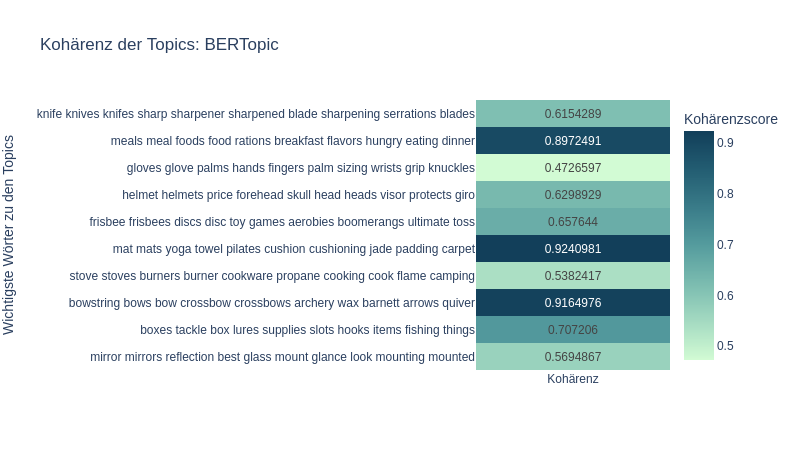

In [ ]:
# Graphische Darstellung
# Speichern der Themenkohörenz und der Topics in einem DataFrame
score_per_topic_df = pd.DataFrame(data=zip(topic_list, coherence_per_topic), columns=['Topic', 'Kohärenz'])

# Umwandeln der Topics in einen string
for index, row in score_per_topic_df.iterrows():
  score_per_topic_df.at[index,"Topic"] = " ".join(row.Topic)

# Setzten des der Liste von Wörter (der Topics) als Index
score_per_topic_df = score_per_topic_df.set_index('Topic')

# Darstellung der Themenkohärenz in einer Heatmap
fig_topic_coherence = px.imshow(score_per_topic_df, text_auto=True, aspect="auto", color_continuous_scale=px.colors.sequential.Darkmint, title = "Kohärenz der Topics: BERTopic",
                                labels = dict(color = "Kohärenzscore", y = "Wichtigste Wörter zu den Topics"), height = 600, width = 800)

# Speichern in ein HTML File
fig_topic_coherence.write_html("BERT_Coherence.html")

# Ausgabe
gitly.show(fig_topic_coherence)

### 5.1.2. Perplexity

Die Perplexity gibt Aufschluss darüber wie gut ein Modell neue Daten verallgemeinern und vorhersagen kann, indem es den Abstand der Themenverteilung des Modells und der gleichmäßigen Wortverteilung des erstellten Wörterbuches misst (Rüdiger, Antons, Joshi, & Salge, 2022). Ein Modell hat ein „gutes Verständnis“ über eine Sprache, wenn es ein semantisch korrektes und häufig auftretendes Wort eine hohe Wahrscheinlichkeit zuweist und einem Seltenem eine niedrige Wahrscheinlichkeit. Aufgrund der umgekehrten Wahrscheinlichkeit, ist eine geringe Perplexity als eine hohe Performence des Modells zu interpretieren (Campagnola, 2020).

In [ ]:
# Errechnung der logaritmische Perplexity
# Quelle: https://huggingface.co/docs/transformers/perplexity
log_perplexity = -1 * np.mean(np.log(np.sum(probabilities, axis=1)))
perplexity = np.exp(log_perplexity)

# Ausgabe
print('Die Perplexity für BERTopic beträgt: ', perplexity)

Die Perplexity für BERTopic beträgt:  1.6822589710747784


### 5.1.1. Similarity

Die „Cosine Similarity“ gibt ein Maß für die Ähnlichkeit zweier Vektoren wieder, welche sich in einem mehrdimensionalen Raum befinden. Der Score basiert auf dem Kosinus der Winkelmessung und bezieht sich auf die Orientierung der Vektoren im Raum anstatt auf deren Länge(Sitikhu, Pahi, Thapa, & Shakya, 2019, S. 2).
Das Ergebnis der Kosinusähnlichkeit kann zwischen -1 und 1 liegen. Wenn ein Winkel zwischen zwei Vektoren klein ist, tendiert der Kosinus des Winkels gegen eins, was sich als ein hohes Maß an Ähnlichkeit interpretieren lässt. Je größer der Winkel wird, desto unähnlicher sind sich die Dokumente. Bei 90° und einem Kosinus Wert um null spricht man von orthogonalen Vektoren. Nimmt Kosinus den Wert -1 an, so nähert sich deren Winkel 180° und die Reviews bzw. Wörter sind mit einem gegenteiligen Inhalt zu interpretieren (Supe, 2023).

Befor die Similarity Scores berechnet werden können, müssen die Daten noch in das passende Format transformiert werden:


In [ ]:
# Extraktion der Embeddings
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/topics.html#bertopic.plotting._topics.visualize_topics
all_topics = sorted(list(bert_model.get_topics().keys()))
indices = np.array([all_topics.index(topic) for topic in topics])
embeddings = bert_model.topic_embeddings_[indices]

# Speichern der Embeddings in einer Liste
embeddings = embeddings.tolist()

# Hinzufügen der Vektoren zu den Dokumentendaten
documents_df["Vector"] = embeddings

# Erstellen einer leeren Liste für die Vectoren
vector_dict = {}

# Extrahieren der Topics
topics_unique = np.sort(documents_df.Topic_number.unique())

# Befüllen des Dictionaries mit den Vectoren pro Topic
for topic in topics_unique:
  vector_dict[str(topic)] = documents_df.loc[documents_df["Topic_number"] == topic].Vector.tolist()

# Selektion der ersten/wichtigsten 10 Topics
# Zu selektierende Keys
selected_keys = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

# Auslesen des Dictionaries "vector_dict" und speichern in neuem Dictionary
vector_select_dict = {}
for key in selected_keys:
    if key in vector_dict:
        vector_select_dict[key] = vector_dict[key]

####__Similarity zwischen den Reviews eines Topics__

Um zu identifizieren, ob sich die Reviews innerhalb eines Topics ähndeln und somit auf einen gleichen Inhalt geschlussfolgert werden kann, wird im folgeden der Similarity Score zwischen den Reviews innerhalt eines Topics berechnent.
Je weiter die Werte gegen 1 tendieren, desto ähnlicher sind die Reviews, welche diesem Topic zugeordnet wurden (Supe, 2023).

In [ ]:
# Similarity Scores pro Topic
# Quelle: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
# Erstellen eines DataFrames für die ersten/ wichtigsten 10 Topics
similarity_df = pd.DataFrame(topics_unique[1:11], columns=["Topic_number"])
similarity_df["Similarity"] = ""

# Schleife zur Errechnung des Similarity Scores pro Topic
for key in vector_select_dict:
  similarity = cosine_similarity(vector_select_dict[key]).mean()
  similarity_df.loc[similarity_df["Topic_number"] == int(key), "Similarity"] = similarity

# Konvertierung der Spalten in das richtige Datenformat
similarity_df["Topic_number"] = similarity_df["Topic_number"].astype(str)
similarity_df["Similarity"] = similarity_df["Similarity"].astype(float)

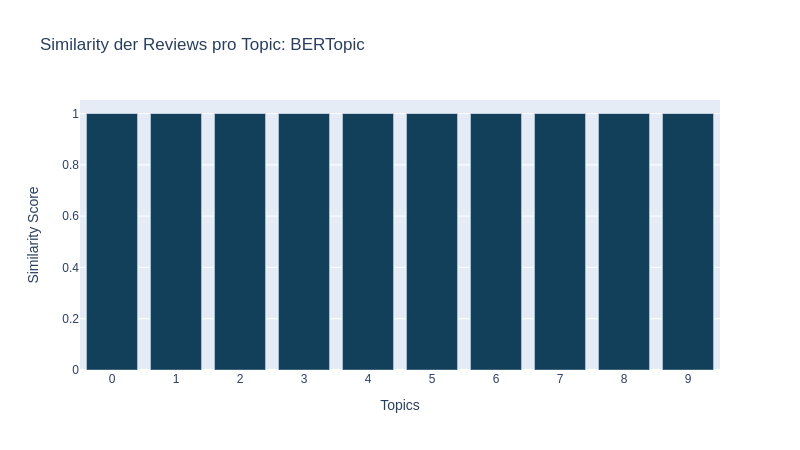

In [ ]:
# Graphische Darstellung
similarity_fig = px.bar(similarity_df, x="Topic_number", y="Similarity", title="Similarity der Reviews pro Topic: BERTopic",
                        color_discrete_sequence=px.colors.sequential.Darkmint_r)

# Update Layout
similarity_fig.update_xaxes(title_text= "Topics")
similarity_fig.update_yaxes(title_text= "Similarity Score")

# Speichern in ein HTML File
similarity_fig.write_html("BERT_Similarity_per_Topic.html")

# Ausgabe
gitly.show(similarity_fig)

####__Topic Similarity Matrix__

Mithilfe der Topic Similarity Matrix lassen sich ähnliche Topics identifizieren, welche sich mit ähnlichen Inhalten befassen. Hierfür wurde die standartisierte Heatmap "Topic Similarity Matrix" von BERTopic implementiert (Grootendorst, Heatmap, 2023). Die Diagonale bildet den Similarity Score des Topics ab, welches bereits im Schritt zuvor berechnet wurde.

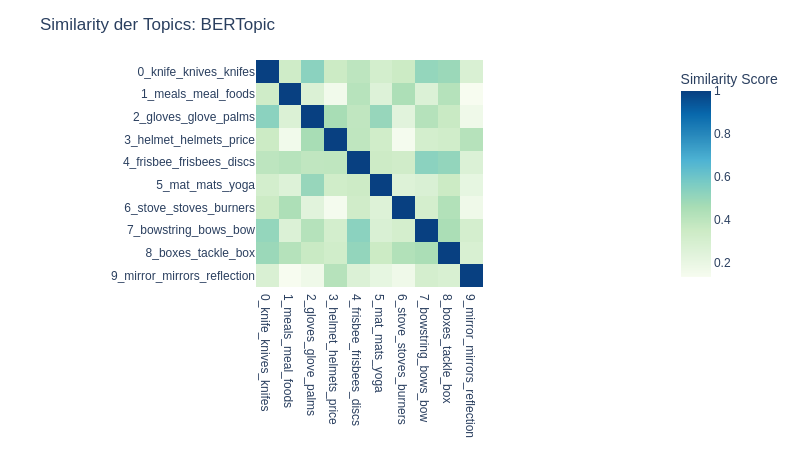

In [ ]:
# Visualisierung des Similarity Scores über eine Heatmap
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/heatmap.html
similarity_topics_fig = bert_model.visualize_heatmap(top_n_topics=10)
similarity_topics_fig.update_layout(title= "Similarity der Topics: BERTopic")

# Speichern in einem HTML File
similarity_topics_fig.write_html("BERT_Similarity_between_Topic.html")

# Ausgabe
gitly.show(similarity_topics_fig)

#### __Intertopic Distanz der Topics__

Mithilfe der Intertopic Distanz Map lässt sich die Entfernung zwischen den Themen messen. Je ähnlicher sich die Themen sind, desto näher liegen diese beieinander und können sich sogar überlappen, falls diese teilweise identische Inhalte aufweisen. Je weiter die Blasen in dem Diagramm voneinander entfernt sind, desto mehr unterscheiden sich die Themen voneinander. Die Größe der Kreise repräsentieren die Anzahl der im Topic enthaltenen Reviews (Amy, 2022). BERTopic hat hier für eine standardmäßige Visualisierung, welche im Rahmen dieser Masterarbeit implementiert wurde (Grootendorst, Topics, 2023).

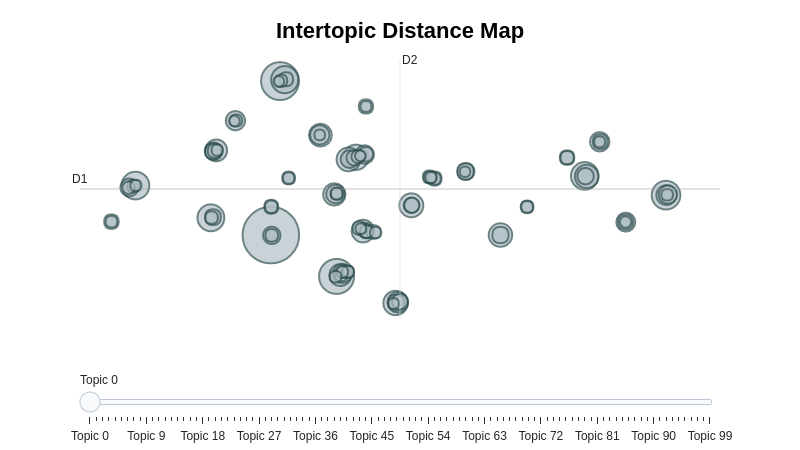

In [ ]:
# Visualisierung der Intertopic-Distance Map
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/topics.html#bertopic.plotting._topics.visualize_topics
intertopic_distanz_fig = bert_model.visualize_topics(top_n_topics=100)

# Speichern in einem HTML File
intertopic_distanz_fig.write_html("BERT_Intertopic_Distance_Map.html")

# Ausgabe
gitly.show(intertopic_distanz_fig)

#### __Hierarchisches Clustering__

Mithilfe dieser Visualisierungsform, lassen sich die  hierarchische Struktur der Topics visualisieren. Auf diese Weise lassen sich die Inhaltlichen Beziehungen von Themen identifizieren, welche miteinander Verbunden sind. Des weiteren werden Themengruppen erseichtlich sowie eine Strukturierung in Unter- und Überthemen. BERTopic hat hierfür ebenfalls eine standardmäßige Visualisierung implementiert. Diese verwendet eine Ward-Linkage-Funktion von Plotly, welche die hierarchische Clusterbildung auf Basis der Kosinus-Similarity-Distanzmatrix berechnet (Grootendorst, Hierarchy, 2023).

In [ ]:
# Visualisierung der Bezeihungen zwischen Topics mithilfe des "hierachical clustering"
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/hierarchy.html
# Top 10 Topics
hierarchical_topics_10_fig = bert_model.visualize_hierarchy(top_n_topics=10)
hierarchical_topics_10_fig.update_layout(title= "Hierarchical Clustering: BERTopic <br><sup>Der Top 10 Topics</sup>")

# Top 20 Topics
hierarchical_topics_20_fig = bert_model.visualize_hierarchy(top_n_topics=20)
hierarchical_topics_20_fig.update_layout(title= "Hierarchical Clustering: BERTopic <br><sup>Der Top 20 Topics</sup>")

# Speichern in einem HTML File
hierarchical_topics_10_fig.write_html("BERT_Hierachical_Clustering_Top10.html")
hierarchical_topics_20_fig.write_html("BERT_Hierachical_Clustering_Top20.html")

# Ausgabe (nicht möglich, Graphiken können in Github BERTopic/img eingesehen werden)
#gitly.show(hierarchical_topics_10_fig)
#gitly.show(hierarchical_topics_20_fig)

# Ausgabe
hierarchical_topics_10_fig

In [ ]:
hierarchical_topics_20_fig

## 6. Literaturverzeichnis

Amy. (21. 10 2022). Topic Modeling with Deep Learning Using Python BERTopic. Abgerufen am 05. 08 2023 von medium.com: https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504

Bianchi, F. (11. 02 2021). Contextualized Topic Modeling with Python (EACL2021). Abgerufen am 30. 07 2023 von towardsdatascience.com: https://towardsdatascience.com/contextualized-topic-modeling-with-python-eacl2021-eacf6dfa576

Campagnola, C. (18. 05 2020). Perplexity in Language Models. Abgerufen am 24. 07 2023 von towardsdatascience.com: https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

Grootendorst, M. (05. 10 2020). Topic Modeling with BERT. Abgerufen am 30. 04 2023 von towardsdatascience.com: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Grootendorst, M. (14. 04 2023). BERTopic. Abgerufen am 28. 04 2023 von github.com: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#1-embed-documents

Grootendorst, M. (2023). Heatmap. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/heatmap.html#bertopic.plotting._heatmap.visualize_heatmap

Grootendorst, M. (2023). Hierarchy. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/hierarchy.html

Grootendorst, M. (2023). KeyBERTInspired. Abgerufen am 03. 08 2023 von github.io: https://maartengr.github.io/BERTopic/api/representation/keybert.html#bertopic.representation._keybert.KeyBERTInspired.extract_topics

Grootendorst, M. (2023). Topics. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/topics.html

Kapadia, S. (19. 08 2019). Evaluate Topic Models: Latent Dirichlet Allocation (LDA). Abgerufen am 21. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

McInnes, L., Healy, J., & Astels, S. (2016). HDBSCAN. Abgerufen am 02. 08 2023 von hdbscan.readthedocs.io: https://hdbscan.readthedocs.io/en/latest/api.html

Nick, T. P. (11. 02 2023). Topic Modeling with BERTopic: A Cookbook with an End-to-end Example (Part 1). Abgerufen am 28. 04 2023 von medium.com: https://medium.com/@nick-tan/topic-modeling-with-bertopic-a-cookbook-with-an-end-to-end-example-part-1-3ef739b8d9f8

Pascual, F. (26. 09 2019). Topic Modeling: An Introduction. Abgerufen am 13. 12 2022 von monkeylearn.com: https://monkeylearn.com/blog/introduction-to-topic-modeling/

Pedro, J. (10. 01 2022). Understanding Topic Coherence Measures. Abgerufen am 23. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

Rüdiger, M., Antons, D., Joshi, A. M., & Salge, T.-O. (28. 04 2022). Topic modeling revisited: New evidence on algorithm performance and quality metrics. Abgerufen am 13. 06 2023 von journals.plos.org: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0266325

Sitikhu, P., Pahi, K., Thapa, P., & Shakya, S. (31. 10 2019). A Comparison of Semantic Similarity Methods for Maximum Human Interpretability. Abgerufen am 05. 08 2023 von Department of Electronics and Computer Engineering, Tribhuwan University: https://arxiv.org/pdf/1910.09129.pdf

Supe, K. (07. 06 2023). Understanding Cosine Similarity in Python with Scikit-Learn. Abgerufen am 05. 08 2023 von memgraph.com/: https://memgraph.com/blog/cosine-similarity-python-scikit-learn